In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#some aesthetic setting for plotting for the rest of the notebook
sns.set()
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv('flights_train.csv', index_col=0, parse_dates=True)

**Feature for learning trend**

In [2]:
df['timestep'] = range(len(df)) #trend feature

**Features for learning seasonality**

In [3]:
df['month'] = df.index.month
seasonal_dummies = pd.get_dummies(df['month'], prefix='month_') 
#ASSUMPTION: The seasonality is monthly!

**Bringing everything together; create a baseline model**
- i.e. modeling trend and seasonality ONLY.

In [4]:
df = df.merge(seasonal_dummies, left_index=True, right_index=True)

In [5]:
X = df.drop(['passengers', 'month'], axis=1) 

y = df['passengers']

<AxesSubplot:xlabel='date'>

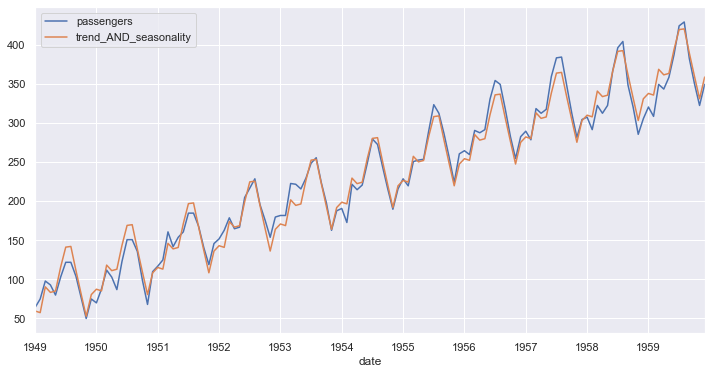

In [6]:
from sklearn.linear_model import LinearRegression
baseline_model = LinearRegression()
baseline_model.fit(X, y)

df['trend_AND_seasonality'] = baseline_model.predict(X)
df[['passengers', 'trend_AND_seasonality']].plot()

**Extract Remainder**

In [7]:
df['remainder'] = df['passengers'] - df['trend_AND_seasonality']

In [8]:
from statsmodels.tsa.ar_model import ar_select_order

In [11]:
ar_select_order(df['remainder'], maxlag=12).ar_lags

array([1])

<AxesSubplot:xlabel='date'>

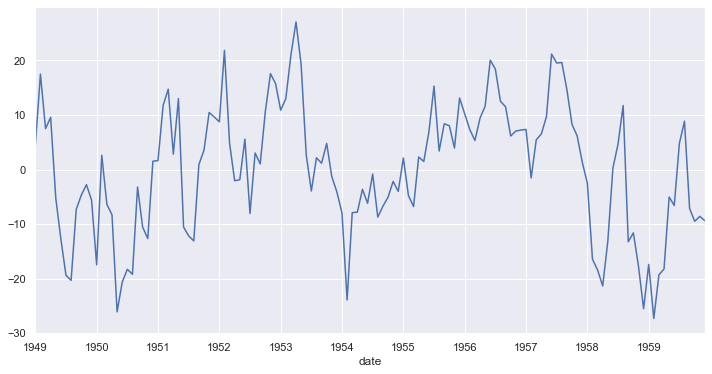

In [12]:
df['remainder'].plot()

### Predicting the Future / Make a "Future DataFrame"

In [13]:
df.tail()

,passengers,timestep,month,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,trend_AND_seasonality,remainder
date,,,,,,,,,,,,,,,,,
1959-08-01,430,127,8,0,0,0,0,0,0,0,1,0,0,0,0,421.132576,8.867424
1959-09-01,383,128,9,0,0,0,0,0,0,0,0,1,0,0,0,390.132576,-7.132576
1959-10-01,351,129,10,0,0,0,0,0,0,0,0,0,1,0,0,360.496212,-9.496212
1959-11-01,323,130,11,0,0,0,0,0,0,0,0,0,0,1,0,331.587121,-8.587121
1959-12-01,350,131,12,0,0,0,0,0,0,0,0,0,0,0,1,359.405303,-9.405303


In [16]:
df_future = pd.DataFrame(index=pd.date_range(start='jan 1960', end='jan 1961', freq='MS'))

In [17]:
df_future.head()

""
1960-01-01
1960-02-01
1960-03-01
1960-04-01
1960-05-01


In [18]:
last_timestep = max(df['timestep'])
last_timestep

131

In [19]:
df_future['timestep'] = range(last_timestep + 1, last_timestep + 1 + len(df_future))

In [24]:
future_seasonal_dummies = pd.get_dummies(df_future.index.month, prefix='month_').set_index(df_future.index)

In [29]:
df_future = pd.concat([df_future, future_seasonal_dummies], axis=1)

In [30]:
df_future.head()

,timestep,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
1960-01-01,132,1,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,133,0,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,134,0,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,135,0,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,136,0,0,0,0,1,0,0,0,0,0,0,0


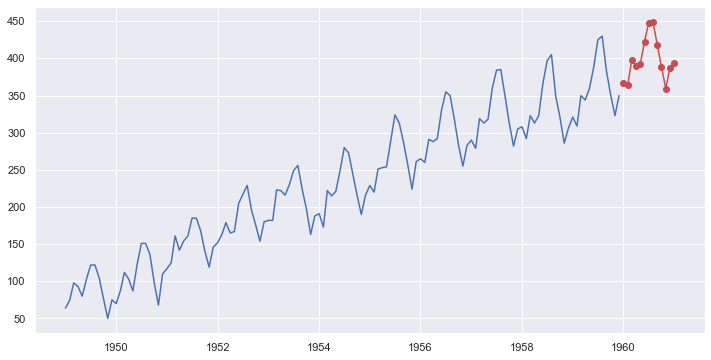

In [38]:
plt.plot(df['passengers'], 'b-')
plt.plot(df_future.index, baseline_model.predict(df_future), 'ro-')

Now let's also make a future prediction for the remainder, so that we can add this to our baseline forecast.

In [39]:
m_remainder = LinearRegression()

In [44]:
m_remainder.fit(df[['remainder']].shift(1)[1:], df['remainder'][1:])
#training a linear regression model on LAST month's remainder, to predict THIS month's remainder

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Right now, it's December 1959. Next month is January 1960.

In [46]:
df[['remainder']][-1:]
# we will use the remainder from THIS month as the input to our trained AR model
# to get the prediction for NEXT MONTH
# i.e. THIS MONTH = NEXT MONTH - 1_lag

,remainder
date,
1959-12-01,-9.405303


In [47]:
m_remainder.predict(df[['remainder']][-1:])

array([-7.23301315])

Similarly, in Statsmodels:

In [48]:
from statsmodels.tsa.ar_model import AutoReg

In [1]:
ar_model = AutoReg(endog=df['remainder'], lags=1).fit()

NameError: name 'AutoReg' is not defined

In [50]:
ar_model.predict(start='jan 1 1960', end='jan 1 1960')

1960-01-01   -7.233013
Freq: MS, dtype: float64

- Our model can currently predict the REMAINDER for next month (future!)
- BUT we also need to add the TREND and SEASONALITY for next month on top!

In [53]:
predicted_remainder = np.zeros(len(df_future))

In [54]:
predicted_remainder[0] = m_remainder.predict(df[['remainder']][-1:])

In [55]:
predicted_remainder

array([-7.23301315,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

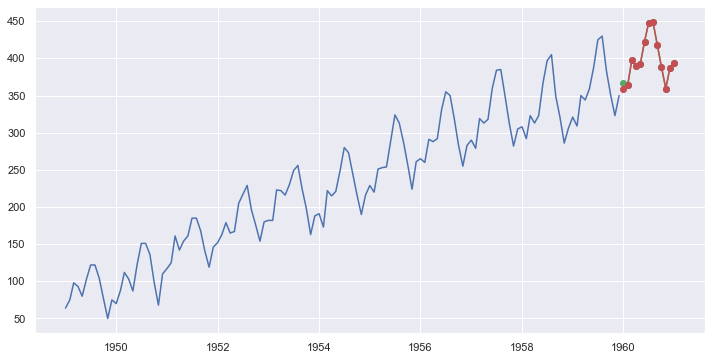

In [60]:
plt.plot(df['passengers'])

plt.plot(df_future.index, baseline_model.predict(df_future), 'go-')
plt.plot(df_future.index, baseline_model.predict(df_future) + predicted_remainder, 'ro-')